# **NOTEBOOK PARA EL ANÁLISIS DE LA MÉTRICA xG POR MINUTO**

In [243]:
#LIBRERÍAS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import json
import statsmodels.api as sm

## **1. Extracción de datos**

In [232]:
#Rutas del archivo ZIP que contiene los diferentes archivos JSON
matches_path = "DATA/matches.zip"
events_path = "DATA/events.zip"
teams_path = "DATA/teams.json"

#Rutas de los archivos JSON que contienen los datos
json_events = "events_World_Cup.json"
json_filename = "matches_World_Cup.json"

In [242]:
#Función para descomprimir los datos y extraerlos
def data_extract(path, json_filename, zip = True):
    if zip:
        with zipfile.ZipFile(path, 'r') as zip_ref:
            with zip_ref.open(json_filename) as file:
                data = json.load(file)
    else:
        with open(path, "r", encoding="utf-8") as file:
            data = json.load(file)

    return data

In [237]:
#Extracción de los datos de partidos y de eventos
data_matches = data_extract(matches_path, json_filename)
data_events = data_extract(events_path, json_events)
data_teams = data_extract(teams_path, None, zip = False)

In [238]:
matches = pd.DataFrame(data_matches)
events = pd.DataFrame(data_events)
teams = pd.DataFrame(data_teams)

In [241]:
print(matches.columns)
print("\n")
print(events.columns)
print("\n")
print(teams.columns)

Index(['status', 'roundId', 'gameweek', 'teamsData', 'seasonId', 'dateutc',
       'winner', 'venue', 'wyId', 'label', 'date', 'groupName', 'referees',
       'duration', 'competitionId'],
      dtype='object')


Index(['eventId', 'subEventName', 'tags', 'playerId', 'positions', 'matchId',
       'eventName', 'teamId', 'matchPeriod', 'eventSec', 'subEventId', 'id'],
      dtype='object')


Index(['city', 'name', 'wyId', 'officialName', 'area', 'type'], dtype='object')


## **2. Preparación y transformación de datos**

In [182]:
# Filtrar tiros
df_tiros = events[events['eventName'] == 'Shot']

In [ ]:
# Función para transformar las coordenadas de la cancha
def transform_coordinates(x, y):
    return (105 * x / 100, 68 * (100 - y) / 100)

# Aplicar la transformación
df_tiros = df_tiros.copy()
df_tiros[['x', 'y']] = df_tiros['positions'].apply(
    lambda pos: pd.Series(transform_coordinates(pos[0]['x'], pos[0]['y']))
)

In [184]:
# Función para calcular la distancia al arco
def calcular_distancia(x, y):
    return np.sqrt((105 - x)**2 + (34 - y)**2)

# Función para calcular el ángulo del tiro
def calcular_angulo(x, y):
    a = 7.32  # Ancho del arco en metros
    distancia_porteria = calcular_distancia(x, y)
    if distancia_porteria == 0:
        return 0
    return np.arcsin(a / distancia_porteria)

# Aplicar las funciones
df_tiros['distance'] = df_tiros.apply(lambda row: calcular_distancia(row['x'], row['y']), axis=1)
df_tiros['angle'] = df_tiros.apply(lambda row: calcular_angulo(row['x'], row['y']), axis=1)

c:\Users\sebas\FootballDataAnalysis\venv\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in arcsin
  # This is added back by InteractiveShellApp.init_path()


In [185]:
# Función para determinar si fue gol
def es_gol(tags):
    return any(tag['id'] == 101 for tag in tags)

# Aplicar la función
df_tiros['goal'] = df_tiros['tags'].apply(es_gol).astype(int)

In [ ]:


# Definir las variables independientes (con una constante) y la dependiente
X = df_tiros[['distance', 'angle']]
X = sm.add_constant(X)
y = df_tiros['goal']



# Ajustar el modelo
#modelo = sm.Logit(y, X).fit()

# Resumen del modelo
#print(modelo.summary())

In [187]:
# Verificar valores NaN en X y y
print(X.isna().sum())
print(y.isna().sum())

# Verificar valores infinitos en X
print(np.isinf(X).sum())

const        0
distance     0
angle       53
dtype: int64
0
const       0
distance    0
angle       0
dtype: int64


In [188]:
X['angle'].fillna(0, inplace=True)
X['distance'].fillna(0, inplace=True)

In [189]:
# Verificar valores NaN en X y y
print(X.isna().sum())
print(y.isna().sum())

# Verificar valores infinitos en X
print(np.isinf(X).sum())

const       0
distance    0
angle       0
dtype: int64
0
const       0
distance    0
angle       0
dtype: int64


In [190]:
import statsmodels.api as sm

# Añadir constante a las variables independientes
X = sm.add_constant(X)

# Ajustar el modelo
modelo = sm.Logit(y, X).fit()

# Resumen del modelo
print(modelo.summary())

Optimization terminated successfully.
         Current function value: 0.259484
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                   goal   No. Observations:                 1419
Model:                          Logit   Df Residuals:                     1416
Method:                           MLE   Df Model:                            2
Date:                Sat, 22 Mar 2025   Pseudo R-squ.:                  0.1436
Time:                        19:38:01   Log-Likelihood:                -368.21
converged:                       True   LL-Null:                       -429.97
Covariance Type:            nonrobust   LLR p-value:                 1.500e-27
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4780      0.341      1.403      0.161      -0.190       1.146
distance      -0.1694      0.

In [191]:
# Calcular xG
df_tiros['xG'] = modelo.predict(X)

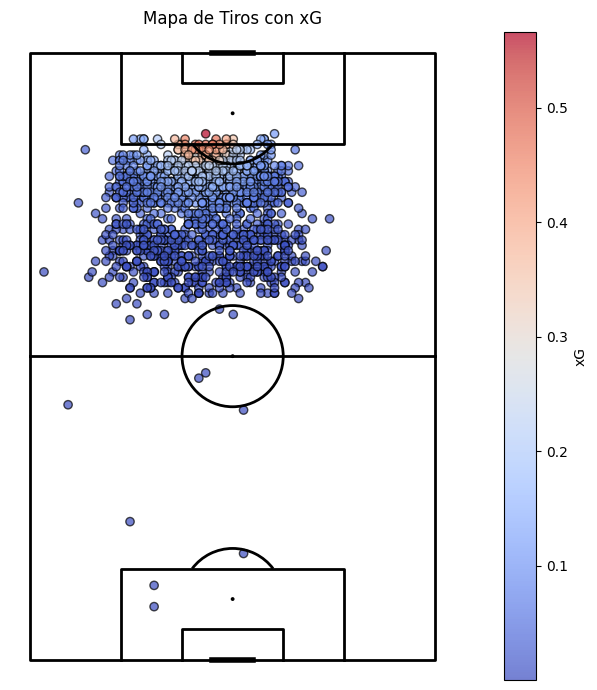

In [192]:
import matplotlib.pyplot as plt
from mplsoccer import VerticalPitch

# Crear una cancha vertical
pitch = VerticalPitch(line_color='black', pitch_color='white', line_zorder=2)
fig, ax = pitch.draw(figsize=(10, 7))

# Graficar los tiros
sc = pitch.scatter(df_tiros['x'], df_tiros['y'], c=df_tiros['xG'], cmap='coolwarm', ax=ax, edgecolors='black', alpha=0.7)
cb = fig.colorbar(sc, ax=ax)
cb.set_label('xG')

plt.title('Mapa de Tiros con xG')
plt.show()

In [193]:
def calcular_minuto(matchPeriod, eventSec):
    if matchPeriod == '1H':
        return eventSec / 60  # Primer tiempo: directamente en minutos
    elif matchPeriod == '2H':
        return 45 + (eventSec / 60)  # Segundo tiempo: sumamos 45 minutos
    return np.nan  # En caso de otros períodos como tiempo extra

df_tiros['minute'] = df_tiros.apply(lambda x: calcular_minuto(x['matchPeriod'], x['eventSec']), axis=1)

In [194]:
print(df_tiros['matchId'].unique())  # Verifica los matchId disponibles
print(12345)   # Compara con el matchId seleccionado


[2057954 2057955 2057956 2057957 2057958 2057959 2057960 2057961 2057962
 2057963 2057964 2057965 2057966 2057967 2057968 2057969 2057970 2057971
 2057972 2057973 2057974 2057975 2057976 2057977 2057978 2057979 2057980
 2057981 2057982 2057983 2057984 2057985 2057986 2057987 2057988 2057989
 2057990 2057991 2057992 2057993 2057994 2057995 2057996 2057997 2057998
 2057999 2058000 2058001 2058002 2058003 2058004 2058005 2058006 2058007
 2058008 2058009 2058010 2058011 2058012 2058013 2058014 2058015 2058016
 2058017]
12345


In [211]:
match_id_seleccionado = 2058017 # Reemplaza con el ID del partido
df_partido = df_tiros[df_tiros['matchId'] == match_id_seleccionado]

In [212]:
df_partido = df_partido.sort_values(by='minute')
df_partido['xG_cumsum'] = df_partido.groupby('teamId')['xG'].cumsum()

In [213]:
import numpy as np
import pandas as pd

# Rango de minutos desde 0 hasta el final del partido (suponiendo 94')
minutos = np.arange(0, 95)

# Crear un DataFrame para almacenar el xG acumulado por equipo
df_xG = pd.DataFrame({'minute': minutos})

for equipo in df_partido['teamId'].unique():
    df_xG[equipo] = np.interp(
        minutos,
        df_partido[df_partido['teamId'] == equipo]['minute'],
        df_partido[df_partido['teamId'] == equipo]['xG_cumsum'],
        left=0, right=np.nan
    )

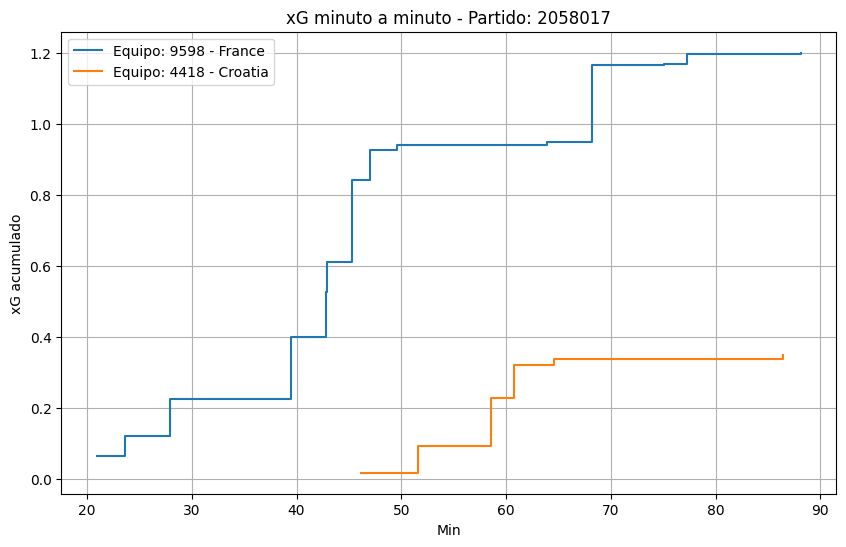

In [221]:
plt.figure(figsize=(10, 6))

teams = ["France", "Croatia"]

for equipo, team in zip(df_partido['teamId'].unique(), teams):
    equipo_df = df_partido[df_partido['teamId'] == equipo]
    #plt.plot(df_xG['minute'], df_xG[equipo], label=f"Equipo {equipo}")
    plt.step(equipo_df['minute'], equipo_df['xG_cumsum'], where='post', label=f"Equipo: {equipo} - {team}")

plt.xlabel('Min')
plt.ylabel('xG acumulado')
plt.title(f"xG minuto a minuto - Partido: {match_id_seleccionado}")
plt.legend()
plt.grid(True)
plt.show()


In [215]:
print(df_partido.head())
print(df_partido[['minute', 'teamId', 'xG']].describe())


        eventId subEventName  \
100629       10         Shot   
100671       10         Shot   
100731       10         Shot   
100813       10         Shot   
100872       10         Shot   

                                                     tags  playerId  \
100629  [{'id': 403}, {'id': 201}, {'id': 1215}, {'id'...     69396   
100671          [{'id': 401}, {'id': 1216}, {'id': 1802}]      3476   
100731  [{'id': 101}, {'id': 401}, {'id': 201}, {'id':...     14812   
100813  [{'id': 401}, {'id': 2101}, {'id': 201}, {'id'...     69616   
100872  [{'id': 403}, {'id': 2101}, {'id': 201}, {'id'...     14812   

                                         positions  matchId eventName  teamId  \
100629  [{'y': 65, 'x': 86}, {'y': 100, 'x': 100}]  2058017      Shot    9598   
100671  [{'y': 33, 'x': 86}, {'y': 100, 'x': 100}]  2058017      Shot    9598   
100731  [{'y': 42, 'x': 87}, {'y': 100, 'x': 100}]  2058017      Shot    9598   
100813  [{'y': 51, 'x': 90}, {'y': 100, 'x': 100}]  2058

In [219]:
import json
import pandas as pd

# 1. Carga el archivo Teams.json
with open("DATA/teams.json", "r", encoding="utf-8") as f:
    teams_data = json.load(f)

# 2. Convierte la lista de diccionarios a un DataFrame
teams_df = pd.DataFrame(teams_data)

# 3. Filtro para los equipos con wyId 14358 o 16129
filtro_ids = [9598, 4418]
equipos_filtrados = teams_df[teams_df['wyId'].isin(filtro_ids)]

print(equipos_filtrados)

       city     name  wyId officialName  \
128  Zagreb  Croatia  9598      Croatia   
135   Paris   France  4418       France   

                                                  area      type  
128  {'name': 'Croatia', 'id': 191, 'alpha3code': '...  national  
135  {'name': 'France', 'id': 250, 'alpha3code': 'F...  national  


In [ ]:
filtro_ids = [9598, 4418]
equipos_filtrados = teams[teams['wyId'].isin(filtro_ids)]

print(equipos_filtrados)